<a href="https://colab.research.google.com/github/EdonFetaji/DataScience/blob/main/labs/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/EdonFetaji/DataScience/refs/heads/main/dataSets/climate-data.csv',parse_dates=['date'],index_col='date')
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


Explore the dataset using visualizations of your choice.

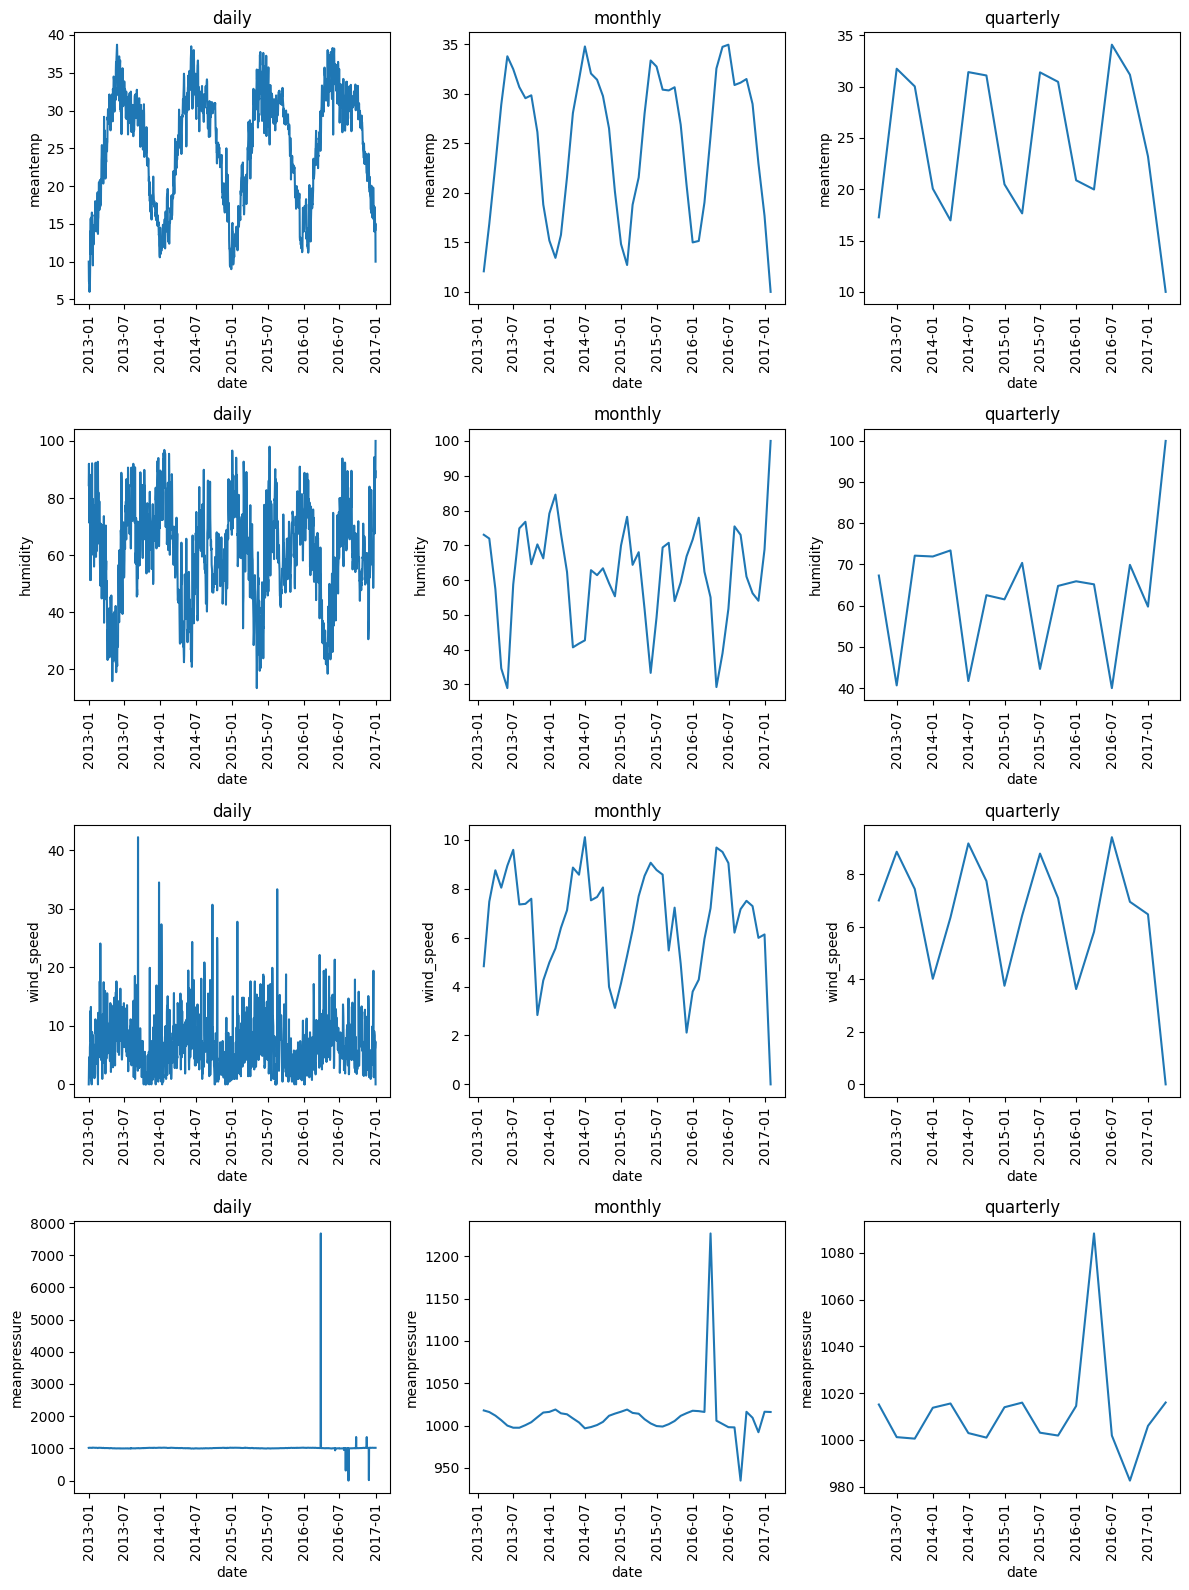

In [12]:
fig = plt.figure(figsize=(12,16))
i=0;
for col in df.columns:
  axis=fig.add_subplot(4,3,i*3+1)
  axis.set_title('daily')
  sns.lineplot(data=df,x=df.index,y=col,ax=axis)
  plt.xticks(rotation=90)

  monthly = df[col].resample('ME').mean()
  axis=fig.add_subplot(4,3,i*3+2)
  axis.set_title('monthly')
  sns.lineplot(x=monthly.index,y=monthly,ax=axis)
  plt.xticks(rotation=90)


  quarterly = df[col].resample('QE').mean()
  axis=fig.add_subplot(4,3,i*3+3)
  axis.set_title('quarterly')
  sns.lineplot(x=quarterly.index,y=quarterly,ax=axis)
  plt.xticks(rotation=90)
  i+=1

fig.tight_layout()
plt.show()

In [13]:
df.isna().sum()

,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [14]:
for col in df.columns:
  for lag in [1,2,3]:
    df[f"{col}_lag_{lag}"] = df[col].shift(lag)


In [17]:
df_clean = df.dropna()
df_clean.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_lag_1,meantemp_lag_2,meantemp_lag_3,humidity_lag_1,humidity_lag_2,humidity_lag_3,wind_speed_lag_1,wind_speed_lag_2,wind_speed_lag_3,meanpressure_lag_1,meanpressure_lag_2,meanpressure_lag_3
date,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,7.400000,10.000000,87.000000,92.000000,84.500000,4.633333,2.980000,0.000000,1018.666667,1017.800000,1015.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,7.166667,7.400000,71.333333,87.000000,92.000000,1.233333,4.633333,2.980000,1017.166667,1018.666667,1017.800000
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,8.666667,7.166667,86.833333,71.333333,87.000000,3.700000,1.233333,4.633333,1016.500000,1017.166667,1018.666667
2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,6.000000,8.666667,82.800000,86.833333,71.333333,1.480000,3.700000,1.233333,1018.000000,1016.500000,1017.166667
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,6.000000,78.600000,82.800000,86.833333,6.300000,1.480000,3.700000,1020.000000,1018.000000,1016.500000


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [21]:
x = df_clean.drop(columns=['meantemp'],axis=1)
y= df_clean['meantemp']

In [25]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,shuffle=False)

In [47]:
def scale_data(train_x,test_x):
  scaler = StandardScaler()

  train_x_scaled = scaler.fit_transform(train_x)
  test_x_scaled = scaler.transform(test_x)

  return train_x_scaled,test_x_scaled


In [ ]:
train_x_scaled,test_x_scaled = scale_data(train_x,test_x)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [30]:
model = RandomForestRegressor(max_depth=11,criterion='squared_error')

In [32]:
model.fit(train_x_scaled,train_y)

RandomForestRegressor(max_depth=11)

Use the trained model to make predictions for the test set.

In [33]:
pred_y= model.predict(test_x_scaled)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [36]:
def evaluate_prediction(orig_y,pred_y):
  print(f"MSE: ",mean_squared_error(orig_y,pred_y))
  print(f"MAbsolutE: ",mean_absolute_error(orig_y,pred_y))
  print(f"R2 SCORE: ",r2_score(orig_y,pred_y))


In [37]:
evaluate_prediction(test_y,pred_y)

MSE:  2.089385340352972
MAbsolutE:  1.1378908739464662
R2 SCORE:  0.9347709706342004


### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [41]:
xg_model = XGBRegressor()
xg_model.fit(train_x_scaled,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [42]:
pred_y = xg_model.predict(test_x_scaled)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [43]:
evaluate_prediction(test_y,pred_y)

MSE:  2.160813669667346
MAbsolutE:  1.1498660830391667
R2 SCORE:  0.9325410322401604


# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [45]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.1,shuffle=False)

In [48]:
train_x_scaled,test_x_scaled = scale_data(train_x,test_x)


## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [46]:
param_grid = {
    'n_estimators':[75,90 ,100,115,145]
}

tss= TimeSeriesSplit(n_splits=5)

In [49]:
grid_search =  GridSearchCV(estimator=xg_model,param_grid=param_grid,cv=tss,scoring='neg_mean_squared_error')

grid_search.fit(train_x_scaled,train_y)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'n_estimators': [75, 90, 100, 115, 145]},
             scoring='neg_mean_squared_error')

In [50]:
best_estimator = grid_search.best_estimator_

In [51]:
print('Most suitable n_estimators is: ', best_estimator.n_estimators)

Most suitable n_estimators is:  115


## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [52]:
pred_y = best_estimator.predict(test_x_scaled)

In [53]:
evaluate_prediction(test_y,pred_y)

MSE:  1.5224765281186536
MAbsolutE:  0.960077495046351
R2 SCORE:  0.9532451250374648
